In [2]:
import os
os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation')

In [1]:
import numpy as np 
import xarray as xr 
import pandas as pd 
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.units as units
from utils.helper_funcs import localize_time
import utils.helper_funcs as hf
import datetime as dt

# Winter 2022 Energy Balance

In [2]:
winter_22 = slice('2021-12-07', '2022-03-31')
# load the 2022 site data
w22_splash_ap_ds = xr.open_dataset('./01_data/processed_data/splash/w22_splash_ap_qc_30min.nc').sel(time=winter_22)
w22_splash_ap_ds = localize_time(w22_splash_ap_ds)

In [3]:
# load in the big events from winter 2022
w22_long_events = pd.read_csv('./01_data/processed_data/sublimation/w22_long_evts.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')
w22_short_events =pd.read_csv('./01_data/processed_data/sublimation/w22_spiky_evts.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')

# drop short december events
w22_short_events = w22_short_events.loc['2022-01-01':]

# get the start and end dateindexs of the events
long_events_start = w22_long_events.reset_index().groupby('event_number').first()['index']
long_events_end = w22_long_events.reset_index().groupby('event_number').last()['index']
short_events_start = w22_short_events.reset_index().groupby('event_number').first()['index']
short_events_end = w22_short_events.reset_index().groupby('event_number').last()['index']

# convert to UTC index and then to MST and then localize
long_events_start = long_events_start.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
long_events_end = long_events_end.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
short_events_start = short_events_start.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
short_events_end = short_events_end.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)

In [4]:
temperature = w22_splash_ap_ds['temp'] * units.units.degC
wind_speed = w22_splash_ap_ds['wspd_vec_mean']
surface_temperature = w22_splash_ap_ds['skin_temp_surface']
mr = w22_splash_ap_ds['mixing_ratio']/1000
vpd = mpcalc.saturation_vapor_pressure(temperature) - mpcalc.vapor_pressure(w22_splash_ap_ds['atmos_pressure'] * units.units.hPa, mr).metpy.convert_units('Pa')
rnet = (w22_splash_ap_ds['down_short_hemisp'] - w22_splash_ap_ds['up_short_hemisp'] ) + (w22_splash_ap_ds['down_long_hemisp'] - w22_splash_ap_ds['up_long_hemisp'] )
rnet = rnet.where((w22_splash_ap_ds[['down_short_hemisp_qc', 'up_short_hemisp_qc', 'down_long_hemisp_qc', 'up_long_hemisp_qc']]==0).to_pandas().all(axis=1).values, np.nan)
rnet = rnet.where(w22_splash_ap_ds['up_short_hemisp'] - w22_splash_ap_ds['down_short_hemisp'] <=5, np.nan).interpolate_na('time')
latent_heat = w22_splash_ap_ds['Hl']
sensible_heat = w22_splash_ap_ds['Hs']

In [5]:
# get the hourly diurnal average
w22_temperature_hr = temperature.groupby('time.hour').mean()
w22_wind_speed_hr = wind_speed.groupby('time.hour').mean()
w22_surface_temperature_hr = surface_temperature.groupby('time.hour').mean()
w22_vpd_hr = vpd.groupby('time.hour').mean()
w22_rnet_hr = rnet.groupby('time.hour').mean()
w22_latent_heat_hr = latent_heat.groupby('time.hour').mean()
w22_sensible_heat_hr = sensible_heat.groupby('time.hour').mean()

# get hourly diurnal standard deviation
w22_temperature_hr_bottom = temperature.groupby('time.hour').quantile(0.25) 
w22_wind_speed_hr_bottom = wind_speed.groupby('time.hour').quantile(0.25)
w22_surface_temperature_hr_bottom = surface_temperature.groupby('time.hour').quantile(0.25)
w22_vpd_hr_bottom = vpd.groupby('time.hour').quantile(0.25)
w22_rnet_hr_bottom = rnet.groupby('time.hour').quantile(0.25)
w22_latent_heat_hr_bottom = latent_heat.groupby('time.hour').quantile(0.25)
w22_sensible_heat_hr_bottom = sensible_heat.groupby('time.hour').quantile(0.25)

# get hourly diurnal standard deviation
w22_temperature_hr_top = temperature.groupby('time.hour').quantile(0.75) 
w22_wind_speed_hr_top = wind_speed.groupby('time.hour').quantile(0.75)
w22_surface_temperature_hr_top = surface_temperature.groupby('time.hour').quantile(0.75)
w22_vpd_hr_top = vpd.groupby('time.hour').quantile(0.75)
w22_rnet_hr_top = rnet.groupby('time.hour').quantile(0.75)
w22_latent_heat_hr_top = latent_heat.groupby('time.hour').quantile(0.75)
w22_sensible_heat_hr_top = sensible_heat.groupby('time.hour').quantile(0.75)


In [6]:
w22_temperature_long_events_hr = []
w22_wind_speed_long_events_hr = []
w22_surface_temperature_long_events_hr = []
w22_vpd_long_events_hr = []
w22_rnet_long_events_hr = []
w22_latent_heat_long_events_hr = []
w22_sensible_heat_long_events_hr = []


for i in range(len(long_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = long_events_start.iloc[i], long_events_end.iloc[i]
    
    # get data for plots
    temperature_sel = temperature.sel(time=slice(start, end))
    wind_speed_sel = wind_speed.sel(time=slice(start, end))
    surface_temperature_sel = surface_temperature.sel(time=slice(start, end))
    vpd_sel = vpd.sel(time=slice(start, end))
    rnet_sel = rnet.sel(time=slice(start, end))
    latent_heat_sel = latent_heat.sel(time=slice(start, end))
    sensible_heat_sel = sensible_heat.sel(time=slice(start, end))

    # append all events to their respective lists
    w22_temperature_long_events_hr.append(temperature_sel)
    w22_wind_speed_long_events_hr.append(wind_speed_sel)
    w22_surface_temperature_long_events_hr.append(surface_temperature_sel)
    w22_vpd_long_events_hr.append(vpd_sel)
    w22_rnet_long_events_hr.append(rnet_sel)
    w22_latent_heat_long_events_hr.append(latent_heat_sel)
    w22_sensible_heat_long_events_hr.append(sensible_heat_sel)


# concatenate all the events
w22_temperature_long_events_hr = xr.concat(w22_temperature_long_events_hr, dim='time').groupby('time.hour').mean()  
w22_wind_speed_long_events_hr = xr.concat(w22_wind_speed_long_events_hr, dim='time').groupby('time.hour').mean()  
w22_surface_temperature_long_events_hr = xr.concat(w22_surface_temperature_long_events_hr, dim='time').groupby('time.hour').mean()  
w22_vpd_long_events_hr = xr.concat(w22_vpd_long_events_hr, dim='time').groupby('time.hour').mean()  
w22_rnet_long_events_hr = xr.concat(w22_rnet_long_events_hr, dim='time').groupby('time.hour').mean()  
w22_latent_heat_long_events_hr = xr.concat(w22_latent_heat_long_events_hr, dim='time').groupby('time.hour').mean()  
w22_sensible_heat_long_events_hr = xr.concat(w22_sensible_heat_long_events_hr, dim='time').groupby('time.hour').mean()  

In [7]:
w22_temperature_short_events_hr = []
w22_wind_speed_short_events_hr = []
w22_surface_temperature_short_events_hr = []
w22_vpd_short_events_hr = []
w22_rnet_short_events_hr = []
w22_latent_heat_short_events_hr = []
w22_sensible_heat_short_events_hr = []


for i in range(len(short_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = short_events_start.iloc[i].date(), short_events_start.iloc[i].date() + pd.Timedelta('1 day')
    
    # get data for plots
    temperature_sel = temperature.sel(time=slice(start, end))
    wind_speed_sel = wind_speed.sel(time=slice(start, end))
    surface_temperature_sel = surface_temperature.sel(time=slice(start, end))
    vpd_sel = vpd.sel(time=slice(start, end))
    rnet_sel = rnet.sel(time=slice(start, end))
    latent_heat_sel = latent_heat.sel(time=slice(start, end))
    sensible_heat_sel = sensible_heat.sel(time=slice(start, end))

    # append all events to their respective lists
    w22_temperature_short_events_hr.append(temperature_sel)
    w22_wind_speed_short_events_hr.append(wind_speed_sel)
    w22_surface_temperature_short_events_hr.append(surface_temperature_sel)
    w22_vpd_short_events_hr.append(vpd_sel)
    w22_rnet_short_events_hr.append(rnet_sel)
    w22_latent_heat_short_events_hr.append(latent_heat_sel)
    w22_sensible_heat_short_events_hr.append(sensible_heat_sel)


# concatenate all the events
w22_temperature_short_events_hr = xr.concat(w22_temperature_short_events_hr, dim='time').groupby('time.hour').mean()  
w22_wind_speed_short_events_hr = xr.concat(w22_wind_speed_short_events_hr, dim='time').groupby('time.hour').mean()  
w22_surface_temperature_short_events_hr = xr.concat(w22_surface_temperature_short_events_hr, dim='time').groupby('time.hour').mean()  
w22_vpd_short_events_hr = xr.concat(w22_vpd_short_events_hr, dim='time').groupby('time.hour').mean()  
w22_rnet_short_events_hr = xr.concat(w22_rnet_short_events_hr, dim='time').groupby('time.hour').mean()  
w22_latent_heat_short_events_hr = xr.concat(w22_latent_heat_short_events_hr, dim='time').groupby('time.hour').mean()  
w22_sensible_heat_short_events_hr = xr.concat(w22_sensible_heat_short_events_hr, dim='time').groupby('time.hour').mean()  

In [8]:
def shade_iqr(ax, top_quartile_array, bottom_quartile_array, color='grey'):
    ax.fill_between(top_quartile_array.hour.values, top_quartile_array.values, bottom_quartile_array.values, color=color, alpha=0.25)
    return ax

## Average for long events

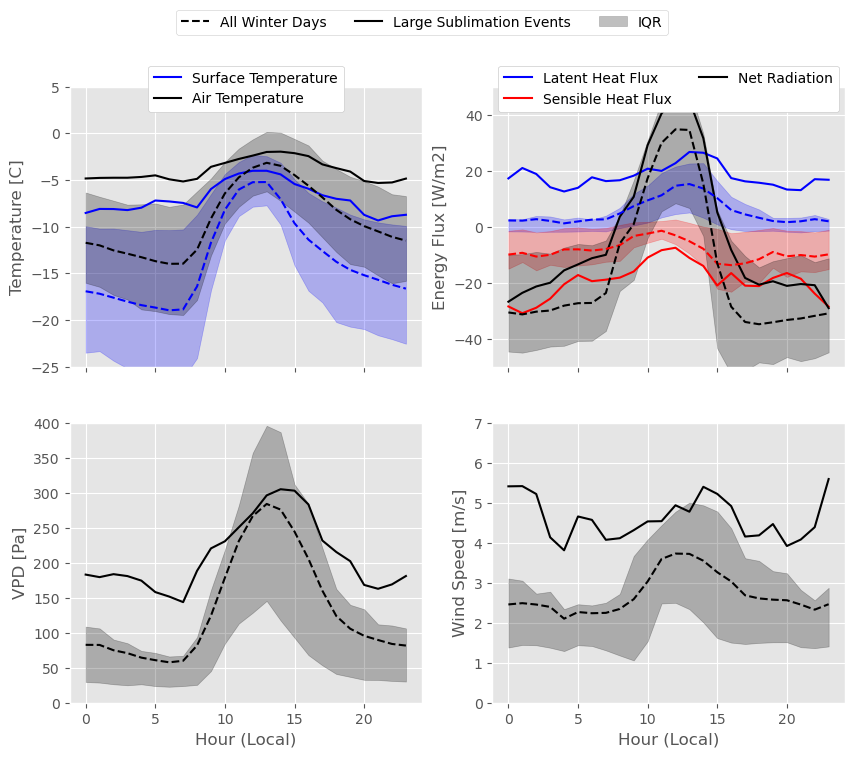

In [9]:
# Compare all winter days to large sublimation events
# plot style
plt.style.use('ggplot')
# Create a figure with gridspec layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()

########## Surface and Air Temperature ##########
# Average values for large sublimation events
axs[0].plot(w22_surface_temperature_long_events_hr.hour.values, w22_surface_temperature_long_events_hr.values, color='blue', label='Surface Temperature', ls='solid')
axs[0].plot(w22_temperature_long_events_hr.hour.values, w22_temperature_long_events_hr.values, label='Air Temperature', color='black', ls='solid')

# Average values for all winter days
axs[0].plot(w22_surface_temperature_hr.hour.values, w22_surface_temperature_hr.values, color='blue', ls='dashed')
shade_iqr(axs[0], w22_surface_temperature_hr_top, w22_surface_temperature_hr_bottom, color='blue')
axs[0].plot(w22_temperature_hr.hour.values, w22_temperature_hr.values, color='black', ls='dashed')
shade_iqr(axs[0], w22_temperature_hr_bottom, w22_temperature_hr_top, color='black')

# ax specs
axs[0].set_ylabel('Temperature [C]')
axs[0].legend(ncol=1, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[0].set_ylim(-25,5)

########## Compare latent heat flux, sensible heat flux, and net radiation ##########
# Average values for large sublimation events
axs[1].plot(w22_latent_heat_long_events_hr.hour.values, w22_latent_heat_long_events_hr.values, color='blue', label='Latent Heat Flux', ls='solid')
axs[1].plot(w22_sensible_heat_long_events_hr.hour.values, w22_sensible_heat_long_events_hr.values, color='red', label='Sensible Heat Flux', ls='solid')
axs[1].plot(w22_rnet_long_events_hr.hour.values, w22_rnet_long_events_hr.values, color='black', label='Net Radiation', ls='solid')

# Average values for all winter days
axs[1].plot(w22_latent_heat_hr.hour.values, w22_latent_heat_hr.values, color='blue', ls='dashed')
shade_iqr(axs[1], w22_latent_heat_hr_top, w22_latent_heat_hr_bottom, color='blue')
axs[1].plot(w22_sensible_heat_hr.hour.values, w22_sensible_heat_hr.values, color='red', ls='dashed')
shade_iqr(axs[1], w22_sensible_heat_hr_top, w22_sensible_heat_hr_bottom, color='red')
axs[1].plot(w22_rnet_hr.hour.values, w22_rnet_hr.values, color='black', ls='dashed')
shade_iqr(axs[1], w22_rnet_hr_top, w22_rnet_hr_bottom, color='black')

# ax specs
axs[1].set_ylabel('Energy Flux [W/m2]')
axs[1].legend(ncol=2, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[1].set_ylim(-50, 50)

########## compare vapor pressure deficit #########
# Average values for large sublimation events
axs[2].plot(w22_vpd_long_events_hr.hour.values, w22_vpd_long_events_hr.values, color='black', ls='solid')

# Average values for all winter days
axs[2].plot(w22_vpd_hr.hour.values, w22_vpd_hr.values, color='black', ls='dashed')
shade_iqr(axs[2], w22_vpd_hr_top, w22_vpd_hr_bottom, color='black')

# ax specs
axs[2].set_ylabel('VPD [Pa]')
axs[2].set_xlabel('Hour (Local)')
axs[2].set_ylim(0,400)

########## compare wind speed ##########
# Average values for large sublimation events
axs[3].plot(w22_wind_speed_long_events_hr.hour.values, w22_wind_speed_long_events_hr.values, color='black', label='Wind Speed @ 10m', ls='solid')

# Average values for all winter days
axs[3].plot(w22_wind_speed_hr.hour.values, w22_wind_speed_hr.values, color='black', ls='dashed')
shade_iqr(axs[3], w22_wind_speed_hr_top, w22_wind_speed_hr_bottom, color='black')
axs[3].set_ylabel('Wind Speed [m/s]')
axs[3].set_xlabel('Hour (Local)')
axs[3].set_ylim(0,7)

###### create dummy plot for legend ######
fake_ax = axs[0].twinx()
# turn off all labels and spines for this axis
fake_ax.axis('off')
fake_ax.plot([],[], color='black', label='All Winter Days', ls='dashed')
fake_ax.plot([],[], color='black', label='Large Sublimation Events', ls='solid')
fake_ax.fill_between([],[],[], color='grey', alpha=0.5, label='IQR')
fake_ax.legend(loc='upper center', bbox_to_anchor=(1., 1.3), ncol=3, facecolor='white')

## Average for short events

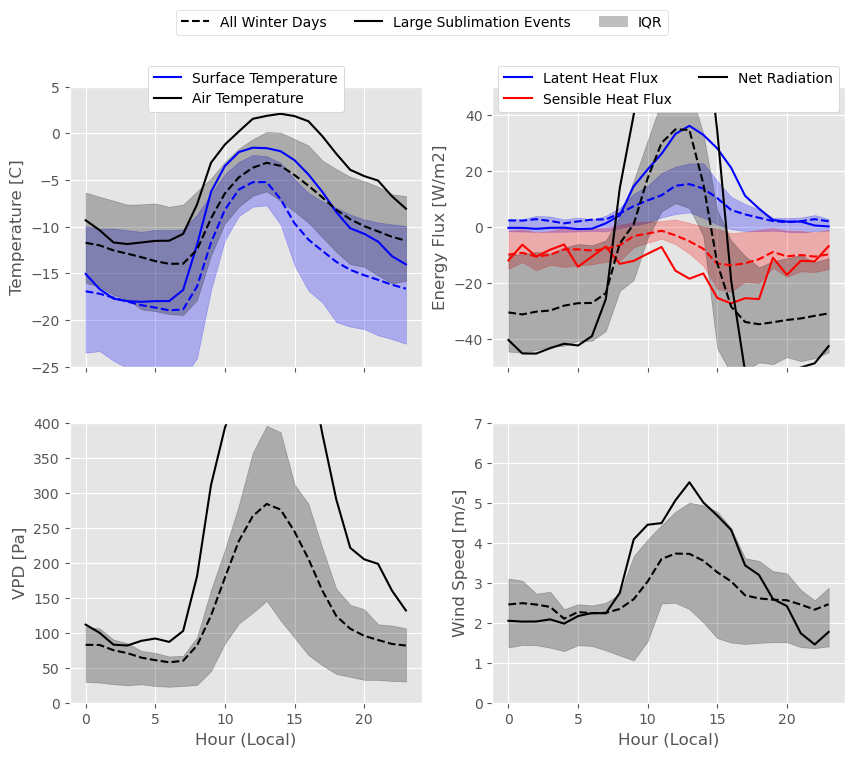

In [10]:
# Compare all winter days to large sublimation events
# plot style
plt.style.use('ggplot')
# Create a figure with gridspec layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()

########## Surface and Air Temperature ##########
# Average values for large sublimation events
axs[0].plot(w22_surface_temperature_short_events_hr.hour.values, w22_surface_temperature_short_events_hr.values, color='blue', label='Surface Temperature', ls='solid')
axs[0].plot(w22_temperature_short_events_hr.hour.values, w22_temperature_short_events_hr.values, label='Air Temperature', color='black', ls='solid')

# Average values for all winter days
axs[0].plot(w22_surface_temperature_hr.hour.values, w22_surface_temperature_hr.values, color='blue', ls='dashed')
shade_iqr(axs[0], w22_surface_temperature_hr_top, w22_surface_temperature_hr_bottom, color='blue')
axs[0].plot(w22_temperature_hr.hour.values, w22_temperature_hr.values, color='black', ls='dashed')
shade_iqr(axs[0], w22_temperature_hr_bottom, w22_temperature_hr_top, color='black')

# ax specs
axs[0].set_ylabel('Temperature [C]')
axs[0].legend(ncol=1, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[0].set_ylim(-25,5)

########## Compare latent heat flux, sensible heat flux, and net radiation ##########
# Average values for large sublimation events
axs[1].plot(w22_latent_heat_short_events_hr.hour.values, w22_latent_heat_short_events_hr.values, color='blue', label='Latent Heat Flux', ls='solid')
axs[1].plot(w22_sensible_heat_short_events_hr.hour.values, w22_sensible_heat_short_events_hr.values, color='red', label='Sensible Heat Flux', ls='solid')
axs[1].plot(w22_rnet_short_events_hr.hour.values, w22_rnet_short_events_hr.values, color='black', label='Net Radiation', ls='solid')

# Average values for all winter days
axs[1].plot(w22_latent_heat_hr.hour.values, w22_latent_heat_hr.values, color='blue', ls='dashed')
shade_iqr(axs[1], w22_latent_heat_hr_top, w22_latent_heat_hr_bottom, color='blue')
axs[1].plot(w22_sensible_heat_hr.hour.values, w22_sensible_heat_hr.values, color='red', ls='dashed')
shade_iqr(axs[1], w22_sensible_heat_hr_top, w22_sensible_heat_hr_bottom, color='red')
axs[1].plot(w22_rnet_hr.hour.values, w22_rnet_hr.values, color='black', ls='dashed')
shade_iqr(axs[1], w22_rnet_hr_top, w22_rnet_hr_bottom, color='black')

# ax specs
axs[1].set_ylabel('Energy Flux [W/m2]')
axs[1].legend(ncol=2, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[1].set_ylim(-50, 50)

########## compare vapor pressure deficit #########
# Average values for large sublimation events
axs[2].plot(w22_vpd_short_events_hr.hour.values, w22_vpd_short_events_hr.values, color='black', ls='solid')

# Average values for all winter days
axs[2].plot(w22_vpd_hr.hour.values, w22_vpd_hr.values, color='black', ls='dashed')
shade_iqr(axs[2], w22_vpd_hr_top, w22_vpd_hr_bottom, color='black')

# ax specs
axs[2].set_ylabel('VPD [Pa]')
axs[2].set_xlabel('Hour (Local)')
axs[2].set_ylim(0,400)

########## compare wind speed ##########
# Average values for large sublimation events
axs[3].plot(w22_wind_speed_short_events_hr.hour.values, w22_wind_speed_short_events_hr.values, color='black', label='Wind Speed @ 10m', ls='solid')

# Average values for all winter days
axs[3].plot(w22_wind_speed_hr.hour.values, w22_wind_speed_hr.values, color='black', ls='dashed')
shade_iqr(axs[3], w22_wind_speed_hr_top, w22_wind_speed_hr_bottom, color='black')
axs[3].set_ylabel('Wind Speed [m/s]')
axs[3].set_xlabel('Hour (Local)')
axs[3].set_ylim(0,7)

###### create dummy plot for legend ######
fake_ax = axs[0].twinx()
# turn off all labels and spines for this axis
fake_ax.axis('off')
fake_ax.plot([],[], color='black', label='All Winter Days', ls='dashed')
fake_ax.plot([],[], color='black', label='Large Sublimation Events', ls='solid')
fake_ax.fill_between([],[],[], color='grey', alpha=0.5, label='IQR')
fake_ax.legend(loc='upper center', bbox_to_anchor=(1., 1.3), ncol=3, facecolor='white')

# Winter 2023 Energy Balance

In [11]:
sos_30min = xr.open_dataset('./01_data/processed_data/sos/sos_ds_30M_storage.nc')

# localize time
sos_30min = localize_time(sos_30min)

In [12]:
def resample_xarray_dataset(ds, resampling_interval):
    """
    Resamples an xarray Dataset by converting it to a pandas DataFrame,
    flattening the index, performing resampling, and converting back to xarray Dataset.
    
    Parameters:
    - ds (xr.Dataset): Input xarray Dataset to be resampled.
    - resampling_interval (str): Resampling interval string (e.g., '1H', '1D', '1M').
    
    Returns:
    - xr.Dataset: Resampled xarray Dataset.
    """
    attrs_dataset = ds.attrs.copy()
    attrs_vars = {var: ds[var].attrs.copy() for var in ds.variables}

    # Convert dataset to pandas DataFrame and flatten the multi-index
    df = ds.to_dataframe()

    # Perform resampling in pandas using agg, all dimension except size_bins should be averaged, size_bins should be constant
    print("Starting computation...")
    start_time = dt.datetime.now()
    ds_resampled = df.resample(resampling_interval).mean().to_xarray()

    end_time = dt.datetime.now()
    print('Duration: {}'.format(end_time - start_time))

    # Restore attributes to the resampled xarray Dataset
    ds_resampled.attrs.update(attrs_dataset)
    for var in ds_resampled.variables:
        ds_resampled[var].attrs.update(attrs_vars.get(var, {}))

    return ds_resampled


In [13]:
splash_radsys_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/splash_data/radsys_ckp_dataset.nc')
# resample to 30min
splash_radsys_30min_ds = resample_xarray_dataset(splash_radsys_ds, '30min').sel(time=sos_30min.time)

Starting computation...
Duration: 0:00:00.268411


In [14]:
# load in the big events from winter 2023
w23_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_long_evts.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')
w23_short_events =pd.read_csv('./01_data/processed_data/sublimation/w23_spiky_evts.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')

# get the start and end datetimes of the events
long_events_start = w23_long_events.reset_index().groupby('event_number').first()['time']
long_events_end = w23_long_events.reset_index().groupby('event_number').last()['time']
short_events_start = w23_short_events.reset_index().groupby('event_number').first()['time']
short_events_end = w23_short_events.reset_index().groupby('event_number').last()['time']

# convert to UTC time and then to MST and then localize
long_events_start = long_events_start.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
long_events_end = long_events_end.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
short_events_start = short_events_start.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
short_events_end = short_events_end.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)

### <a id='toc3_1_2_'></a>[Saturation with respect to ice](#toc0_)

In [15]:
# correct the RH values to make them with respect to ice
def saturation_vapor_pressure_wrt_ice(T, method='Huang'):
    # from Huang et al. 2018
    if method == 'Huang':
        Ps = np.exp(43.494 - (6545.8 / (T + 278.0)))/((T + 868)**2)
    elif method == 'Magnus':
        # From (Alduchov and Eskridge 1996).
        Ps = 611.21 * np.exp((22.587*T)/(T + 273.86))
    return Ps
def saturation_vapor_pressure_wrt_water(T, method='Huang'):
    if method == 'Huang':
        # from Huang et al. 2018
        Ps = np.exp(34.494 - (4924.99 / (T + 237.1)))/((T+105)**1.57)
    if method == 'Magnus':
    # From (Alduchov and Eskridge 1996).
        Ps = 610.94 * np.exp((17.625*T)/(T + 243.04))
    return Ps

cold_temp_array = np.arange(-20, 0, 1)
warm_temp_array = np.arange(-20, 0, 1)
sat_vap_pres_ice_huang = saturation_vapor_pressure_wrt_ice(cold_temp_array)
sat_vap_pres_ice_magnus= saturation_vapor_pressure_wrt_ice(cold_temp_array, method='Magnus')
sat_vap_pres_water_huang = saturation_vapor_pressure_wrt_water(warm_temp_array)
sat_vap_pres_water_magnus = saturation_vapor_pressure_wrt_water(warm_temp_array, method='Magnus')

### Interpolation using diurnal window

In [16]:
def rolling_window_diurnal(df, site, window=dt.timedelta(days=3)):
    """
    This function will take in a dataframe and return a rolling window average for each hour of the day
    """
    # create a new dataframe to hold the results
    subset_df = df[site].copy()
    # print the number of nans
    print(f'Number of NaNs before: {subset_df.isna().sum()}')
    # itierate through the time index
    for i, time in enumerate(subset_df.index):
        # find the missing values
        if np.isnan(subset_df.loc[time]):
            # create a window around the time with missing data
            start_window = time - window
            end_window = time + window
            # get the hourly average for the window
            src = subset_df.loc[start_window:end_window]
            # check if the window has at least 50% measurements data
            if len(src) / 2 >= src.isna().sum():
                interp_val = src.groupby([src.index.hour, src.index.minute]).mean()
                # set a min and max threshold for the interpolation
                interp_val = interp_val.where(interp_val >=0, 0)
                # fill in the missing value
                subset_df.loc[time] = interp_val.loc[time.hour, time.minute]
            else:
                # the value is truly missing
                subset_df.loc[time] = np.nan
    print(f'Number of NaNs after: {subset_df.isna().sum()}')
    return subset_df


### <a id='toc3_1_3_'></a>[Create variables for each desired data product](#toc0_)

Basic Meteorological Variables

In [17]:
sos_30min_RH = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'RH' in var]] 
sos_30min_T = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'T' in var]] * units.units('degC')
sos_30min_winds = sos_30min[[var for var in hf.WIND_VARIABLES if 'spd' in var or 'dir' in var]] 
# surface temperature
sos_30min_Tsurf_d = sos_30min['Tsurfapogee_d'] # can also take spatial mean if I want

In [18]:
# calculate pressure, mixing ratio and air density
heights = np.arange(2,21,1)
pressureprofiles = []
mixingratios = []
airdensities = []
vaporpressures = []
satvaporpressures = []
vpds = []
thetas = []
for h in heights:
    # calculate pressure
    pressure = mpcalc.height_to_pressure_std(
                                mpcalc.pressure_to_height_std(sos_30min['P_10m_c']*units.units('hPa')) - ((10 - h)/1000)*units.units('km'))
    pressure.name = f'P_{h}m_c'
    # calculate mixing ratio
    mixingratio = mpcalc.mixing_ratio_from_relative_humidity(pressure, sos_30min_T[f'T_{h}m_c'], sos_30min_RH[f'RH_{h}m_c'])
    mixingratio.name=f'w_{h}m_c'
    # calculate air density
    airdensity = mpcalc.density(pressure, sos_30min_T[f'T_{h}m_c'], mixingratio)
    airdensity.name = f'rho_{h}m_c'
    # calculate vapor pressure
    vaporpressure = mpcalc.vapor_pressure(pressure, mixingratio)
    vaporpressure.name = f'e_{h}m_c'
    # calculate saturation vapor pressure
    satvaporpressure = saturation_vapor_pressure_wrt_ice(sos_30min_T['T_10m_c'].metpy.dequantify()) * units.units('Pa')
    satvaporpressure.name = f'es_{h}m_c'
    # calculate vapor pressure deficit
    vaporpressuredeficit = satvaporpressure - vaporpressure
    vaporpressuredeficit.name = f'vpd_{h}m_c'
    # calculate potential temperature
    sos_30min_theta = mpcalc.potential_temperature(pressure, sos_30min_T[f'T_{h}m_c'])
    sos_30min_theta.name = f'Theta_{h}m_c'

    # append to lists
    pressureprofiles.append(pressure)
    mixingratios.append(mixingratio)
    airdensities.append(airdensity)
    vaporpressures.append(vaporpressure)
    satvaporpressures.append(satvaporpressure)
    vpds.append(vaporpressuredeficit)
    thetas.append(sos_30min_theta)


# Create xarray datasets
sos_30min_pressure_profiles = xr.merge(pressureprofiles)
sos_30min_mixing_ratio = xr.merge(mixingratios)
sos_30min_airdensity = xr.merge(airdensities) 
sos_30min_vaporpressure = xr.merge(vaporpressures) 
sos_30min_satvaporpressure = xr.merge(satvaporpressures) 
sos_30min_vpd = xr.merge(vpds)
sos_30min_theta = xr.merge(thetas) 

#### Turbulent Flux Variables

In [19]:
# sublimation rate
sos_30min_Hl_webb_3m = pd.read_csv('./01_data/processed_data/sublimation/w23_latent_heat_flux_3m.csv', index_col=0, parse_dates=True).to_xarray()*units.units('J/m^2/s')
# localize the time
sos_30min_Hl_webb_3m['time'] = pd.to_datetime(sos_30min_Hl_webb_3m.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)
sos_30min_ec_temp = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_t_3m' in var]].to_array(dim='3m').mean('3m')

#### Energy Balance Variables

In [20]:
# SOS radiation
sos_30min_rad = sos_30min[[var for var in hf.RADIAION_VARIABLES if 'R' in var]+['R_lw_up', 'R_lw_down']]
# Fill NA values with np.nan
sos_30min_rad = sos_30min_rad.fillna(np.nan)

# SPLASH radiation
splash_dw_solar = splash_radsys_30min_ds['dw_solar'].where((splash_radsys_30min_ds['dw_solar_qc'] == 0) & (splash_radsys_30min_ds['uw_solar_qc'] == 0), np.nan)
splash_up_solar = splash_radsys_30min_ds['uw_solar'].where((splash_radsys_30min_ds['dw_solar_qc'] == 0) & (splash_radsys_30min_ds['uw_solar_qc'] == 0), np.nan)
splash_dw_ir = splash_radsys_30min_ds['dw_ir'].where((splash_radsys_30min_ds['dw_ir_qc'] == 0)& (splash_radsys_30min_ds['uw_ir_qc'] == 0), np.nan)
splash_up_ir = splash_radsys_30min_ds['uw_ir'].where((splash_radsys_30min_ds['dw_ir_qc'] == 0)& (splash_radsys_30min_ds['uw_ir_qc'] == 0), np.nan)

# remove any times when Rsw_in_9m_d is less than Rsw_out_9m_d
sos_30min_rad = sos_30min_rad.where((sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d'])>-10,np.nan)

# if values are missing, replace with splash values
sos_30min_rad['Rsw_in_9m_d'] = sos_30min_rad['Rsw_in_9m_d'].where(sos_30min_rad['Rsw_in_9m_d'].notnull(), splash_dw_solar)
sos_30min_rad['Rsw_out_9m_d'] = sos_30min_rad['Rsw_out_9m_d'].where(sos_30min_rad['Rsw_out_9m_d'].notnull(), splash_up_solar)
sos_30min_rad['R_lw_down'] = sos_30min_rad['R_lw_down'].where(sos_30min_rad['R_lw_down'].notnull(), splash_dw_ir)
sos_30min_rad['R_lw_up'] = sos_30min_rad['R_lw_up'].where(sos_30min_rad['R_lw_up'].notnull(), splash_up_ir)

# # Interpolate other missing values
for variable in sos_30min_rad.data_vars:
    print(variable)
    sos_30min_rad[variable] = rolling_window_diurnal(sos_30min_rad.to_dataframe(), variable, window=dt.timedelta(days=1, hours=12)).to_xarray()
    print('------------')
# calculate net radiation
sos_30min_rad['rnet'] = (sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d']) + (sos_30min_rad['R_lw_down'] - sos_30min_rad['R_lw_up'])


Rpile_out_9m_d
Number of NaNs before: 2967
Number of NaNs after: 1341
------------
Rpile_in_9m_d
Number of NaNs before: 2967
Number of NaNs after: 1341
------------
Rsw_in_9m_d
Number of NaNs before: 588
Number of NaNs after: 143
------------
Rsw_out_9m_d
Number of NaNs before: 588
Number of NaNs after: 143
------------
R_lw_up
Number of NaNs before: 727
Number of NaNs after: 225
------------
R_lw_down
Number of NaNs before: 727
Number of NaNs after: 225
------------


In [21]:
sos_30min_RH_ice = sos_30min_RH.copy()
# covert to RH with respect to ice by multiplying with the ratio of the saturation vapor pressure of water and ice
for var in sos_30min_RH_ice:
    if 'RH' in var:
        T_var = var.replace('RH', 'T')
        # create a mask where T is below 0
        mask = sos_30min_T[T_var] > 0
        # use the mask to calculate RH with respect to ice
        sos_30min_RH_ice[var] = sos_30min_RH_ice[var].where(mask, sos_30min_RH_ice[var] * saturation_vapor_pressure_wrt_water(sos_30min_T[T_var].values)/saturation_vapor_pressure_wrt_ice(sos_30min_T[T_var].values))

In [22]:
# Constant values
rho_w = 1000 * units.units('kg/m^3') # density of water kg/m^3
g2kg = (1/1000 * units.units('kg/g')) # convert from g to kg
mm_per_meter = 1000 * units.units('mm/m') # convert from m to mm
s_in_hour = 3600 * units.units('seconds/hour') # seconds in an hour
latent_heat_sublimation = 2.835e6 * units.units('J/kg') # latent heat of sublimation J/kg
heat_capacity_air = (1005)*units.units('J/kg/degC') # J/kg/C

# Calculate the sensible heat flux
sos_30min_sensible_heat = heat_capacity_air*(sos_30min_ec_temp.sel(time=slice('2022-12-01','2023-03-31'))*units.units('degC * m/s')*sos_30min_airdensity.sel(time=slice('2022-12-01','2023-03-31'))['rho_3m_c']) # convert to W/m^2 from degC * m/s

#### Get all average conditions over winter to compare

In [23]:

w23_temperature_hr = sos_30min_T['T_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').mean()
w23_wind_speed_hr = sos_30min_winds['spd_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').mean()
w23_surface_temperature_hr = sos_30min_Tsurf_d.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').mean()
w23_vpd_hr = sos_30min_vpd['vpd_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').mean()
w23_rnet_hr = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))['rnet'].groupby('time.hour').mean()
w23_latent_heat_hr = sos_30min_Hl_webb_3m.sel(time=slice('2022-12-01','2023-03-31'))['sos_3m'].groupby('time.hour').mean()
w23_sensible_heat_hr = sos_30min_sensible_heat.groupby('time.hour').mean()

# name all the variables
w23_latent_heat_hr.name = 'latent_heat'
w23_sensible_heat_hr.name = 'sensible_heat'

# get the top quartile of each
w23_temperature_hr_top = sos_30min_T['T_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
w23_wind_speed_hr_top = sos_30min_winds['spd_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
w23_surface_temperature_hr_top = sos_30min_Tsurf_d.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
w23_vpd_hr_top = sos_30min_vpd['vpd_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
w23_rnet_hr_top = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))['rnet'].groupby('time.hour').quantile(0.75)
w23_latent_heat_hr_top = sos_30min_Hl_webb_3m.sel(time=slice('2022-12-01','2023-03-31'))['sos_3m'].groupby('time.hour').quantile(0.75)
w23_sensible_heat_hr_top = sos_30min_sensible_heat.groupby('time.hour').quantile(0.75)

# name all the variables
w23_latent_heat_hr_top.name = 'latent_heat'
w23_sensible_heat_hr_top.name = 'sensible_heat'

# get the bottom quartile of each
w23_temperature_hr_bottom = sos_30min_T['T_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
w23_wind_speed_hr_bottom = sos_30min_winds['spd_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
w23_surface_temperature_hr_bottom = sos_30min_Tsurf_d.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
w23_vpd_hr_bottom = sos_30min_vpd['vpd_3m_c'].sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
w23_rnet_hr_bottom = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))['rnet'].groupby('time.hour').quantile(0.25)
w23_latent_heat_hr_bottom = sos_30min_Hl_webb_3m.sel(time=slice('2022-12-01','2023-03-31'))['sos_3m'].groupby('time.hour').quantile(0.25)
w23_sensible_heat_hr_bottom = sos_30min_sensible_heat.groupby('time.hour').quantile(0.25)

# name all the variables
w23_latent_heat_hr_bottom.name = 'latent_heat'
w23_sensible_heat_hr_bottom.name = 'sensible_heat'

In [24]:
w23_temperature_long_events_hr = []
w23_wind_speed_long_events_hr = []
w23_surface_temperature_long_events_hr = []
w23_vpd_long_events_hr = []
w23_rnet_long_events_hr = []
w23_latent_heat_long_events_hr = []
w23_sensible_heat_long_events_hr = []


for i in range(len(long_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = long_events_start.iloc[i], long_events_end.iloc[i]
    
    # get data for plots
    temperature_sel = sos_30min_T['T_3m_c'].sel(time=slice(start, end))
    wind_speed_sel = sos_30min_winds['spd_3m_c'].sel(time=slice(start, end))
    surface_temperature_sel = sos_30min_Tsurf_d.sel(time=slice(start, end))
    vpd_sel = sos_30min_vpd['vpd_3m_c'].sel(time=slice(start, end))
    rnet_sel = sos_30min_rad['rnet'].sel(time=slice(start, end))
    latent_heat_sel = sos_30min_Hl_webb_3m['sos_3m'].sel(time=slice(start, end))
    sensible_heat_sel = sos_30min_sensible_heat.sel(time=slice(start, end))

    # append all events to their respective lists
    w23_temperature_long_events_hr.append(temperature_sel)
    w23_wind_speed_long_events_hr.append(wind_speed_sel)
    w23_surface_temperature_long_events_hr.append(surface_temperature_sel)
    w23_vpd_long_events_hr.append(vpd_sel)
    w23_rnet_long_events_hr.append(rnet_sel)
    w23_latent_heat_long_events_hr.append(latent_heat_sel)
    w23_sensible_heat_long_events_hr.append(sensible_heat_sel)


# concatenate all the events
w23_temperature_long_events_hr = xr.concat(w23_temperature_long_events_hr, dim='time').groupby('time.hour').mean()  
w23_wind_speed_long_events_hr = xr.concat(w23_wind_speed_long_events_hr, dim='time').groupby('time.hour').mean()  
w23_surface_temperature_long_events_hr = xr.concat(w23_surface_temperature_long_events_hr, dim='time').groupby('time.hour').mean()  
w23_vpd_long_events_hr = xr.concat(w23_vpd_long_events_hr, dim='time').groupby('time.hour').mean()  
w23_rnet_long_events_hr = xr.concat(w23_rnet_long_events_hr, dim='time').groupby('time.hour').mean()  
w23_latent_heat_long_events_hr = xr.concat(w23_latent_heat_long_events_hr, dim='time').groupby('time.hour').mean()  
w23_sensible_heat_long_events_hr = xr.concat(w23_sensible_heat_long_events_hr, dim='time').groupby('time.hour').mean()  

## Average for short events

In [25]:
w23_temperature_short_events_hr = []
w23_wind_speed_short_events_hr = []
w23_surface_temperature_short_events_hr = []
w23_vpd_short_events_hr = []
w23_rnet_short_events_hr = []
w23_latent_heat_short_events_hr = []
w23_sensible_heat_short_events_hr = []


for i in range(len(short_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = short_events_start.iloc[i].date(), short_events_start.iloc[i].date() + pd.Timedelta('1 day')
    
    # get data for plots
    temperature_sel = sos_30min_T['T_3m_c'].sel(time=slice(start, end))
    wind_speed_sel = sos_30min_winds['spd_3m_c'].sel(time=slice(start, end))
    surface_temperature_sel = sos_30min_Tsurf_d.sel(time=slice(start, end))
    vpd_sel = sos_30min_vpd['vpd_3m_c'].sel(time=slice(start, end))
    rnet_sel = sos_30min_rad['rnet'].sel(time=slice(start, end))
    latent_heat_sel = sos_30min_Hl_webb_3m['sos_3m'].sel(time=slice(start, end))
    sensible_heat_sel = sos_30min_sensible_heat.sel(time=slice(start, end))

    # append all events to their respective lists
    w23_temperature_short_events_hr.append(temperature_sel)
    w23_wind_speed_short_events_hr.append(wind_speed_sel)
    w23_surface_temperature_short_events_hr.append(surface_temperature_sel)
    w23_vpd_short_events_hr.append(vpd_sel)
    w23_rnet_short_events_hr.append(rnet_sel)
    w23_latent_heat_short_events_hr.append(latent_heat_sel)
    w23_sensible_heat_short_events_hr.append(sensible_heat_sel)


# concatenate all the events
w23_temperature_short_events_hr = xr.concat(w23_temperature_short_events_hr, dim='time').groupby('time.hour').mean()  
w23_wind_speed_short_events_hr = xr.concat(w23_wind_speed_short_events_hr, dim='time').groupby('time.hour').mean()  
w23_surface_temperature_short_events_hr = xr.concat(w23_surface_temperature_short_events_hr, dim='time').groupby('time.hour').mean()  
w23_vpd_short_events_hr = xr.concat(w23_vpd_short_events_hr, dim='time').groupby('time.hour').mean()  
w23_rnet_short_events_hr = xr.concat(w23_rnet_short_events_hr, dim='time').groupby('time.hour').mean()  
w23_latent_heat_short_events_hr = xr.concat(w23_latent_heat_short_events_hr, dim='time').groupby('time.hour').mean()  
w23_sensible_heat_short_events_hr = xr.concat(w23_sensible_heat_short_events_hr, dim='time').groupby('time.hour').mean()  

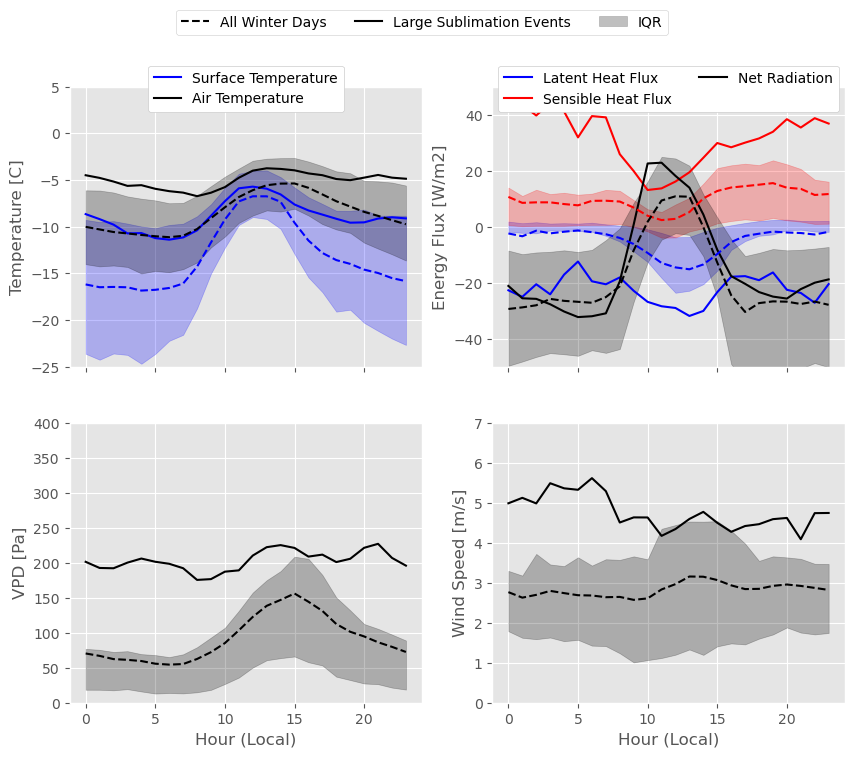

In [26]:
# Compare all winter days to large sublimation events
# plot style
plt.style.use('ggplot')
# Create a figure with gridspec layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()

#----------- Surface and Air Temperature -----------
# Average values for large sublimation events
axs[0].plot(w23_surface_temperature_long_events_hr.hour.values, w23_surface_temperature_long_events_hr.values, color='blue', label='Surface Temperature', ls='solid')
axs[0].plot(w23_temperature_long_events_hr.hour.values, w23_temperature_long_events_hr.values, label='Air Temperature', color='black', ls='solid')

# Average values for all winter days
axs[0].plot(w23_surface_temperature_hr.hour.values, w23_surface_temperature_hr.values, color='blue', ls='dashed')
shade_iqr(axs[0], w23_surface_temperature_hr_top, w23_surface_temperature_hr_bottom, color='blue')
axs[0].plot(w23_temperature_hr.hour.values, w23_temperature_hr.values, color='black', ls='dashed')
shade_iqr(axs[0], w23_temperature_hr_bottom, w23_temperature_hr_top, color='black')

# ax specs
axs[0].set_ylabel('Temperature [C]')
axs[0].legend(ncol=1, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[0].set_ylim(-25,5)

#----------- Compare latent heat flux, sensible heat flux, and net radiation -----------
# Average values for large sublimation events
axs[1].plot(w23_latent_heat_long_events_hr.hour.values, -w23_latent_heat_long_events_hr.values, color='blue', label='Latent Heat Flux', ls='solid')
axs[1].plot(w23_sensible_heat_long_events_hr.hour.values, -w23_sensible_heat_long_events_hr.values, color='red', label='Sensible Heat Flux', ls='solid')
axs[1].plot(w23_rnet_long_events_hr.hour.values, w23_rnet_long_events_hr.values, color='black', label='Net Radiation', ls='solid')

# Average values for all winter days
axs[1].plot(w23_latent_heat_hr.hour.values, -w23_latent_heat_hr.values, color='blue', ls='dashed')
shade_iqr(axs[1], -w23_latent_heat_hr_top, -w23_latent_heat_hr_bottom, color='blue')
axs[1].plot(w23_sensible_heat_hr.hour.values, -w23_sensible_heat_hr.values, color='red', ls='dashed')
shade_iqr(axs[1], -w23_sensible_heat_hr_top, -w23_sensible_heat_hr_bottom, color='red')
axs[1].plot(w23_rnet_hr.hour.values, w23_rnet_hr.values, color='black', ls='dashed')
shade_iqr(axs[1], w23_rnet_hr_top, w23_rnet_hr_bottom, color='black')

# ax specs
axs[1].set_ylabel('Energy Flux [W/m2]')
axs[1].legend(ncol=2, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[1].set_ylim(-50, 50)

#----------- compare vapor pressure deficit -----------
# Average values for large sublimation events
axs[2].plot(w23_vpd_long_events_hr.hour.values, w23_vpd_long_events_hr.values, color='black', ls='solid')

# Average values for all winter days
axs[2].plot(w23_vpd_hr.hour.values, w23_vpd_hr.values, color='black', ls='dashed')
shade_iqr(axs[2], w23_vpd_hr_top, w23_vpd_hr_bottom, color='black')

# ax specs
axs[2].set_ylabel('VPD [Pa]')
axs[2].set_xlabel('Hour (Local)')
axs[2].set_ylim(0,400)

#----------- compare wind speed -----------
# Average values for large sublimation events
axs[3].plot(w23_wind_speed_long_events_hr.hour.values, w23_wind_speed_long_events_hr.values, color='black', label='Wind Speed @ 10m', ls='solid')

# Average values for all winter days
axs[3].plot(w23_wind_speed_hr.hour.values, w23_wind_speed_hr.values, color='black', ls='dashed')
shade_iqr(axs[3], w23_wind_speed_hr_top, w23_wind_speed_hr_bottom, color='black')
axs[3].set_ylabel('Wind Speed [m/s]')
axs[3].set_xlabel('Hour (Local)')
axs[3].set_ylim(0,7)

###### create dummy plot for legend ######
fake_ax = axs[0].twinx()
# turn off all labels and spines for this axis
fake_ax.axis('off')
fake_ax.plot([],[], color='black', label='All Winter Days', ls='dashed')
fake_ax.plot([],[], color='black', label='Large Sublimation Events', ls='solid')
fake_ax.fill_between([],[],[], color='grey', alpha=0.5, label='IQR')
fake_ax.legend(loc='upper center', bbox_to_anchor=(1., 1.3), ncol=3, facecolor='white')

## Average for short events

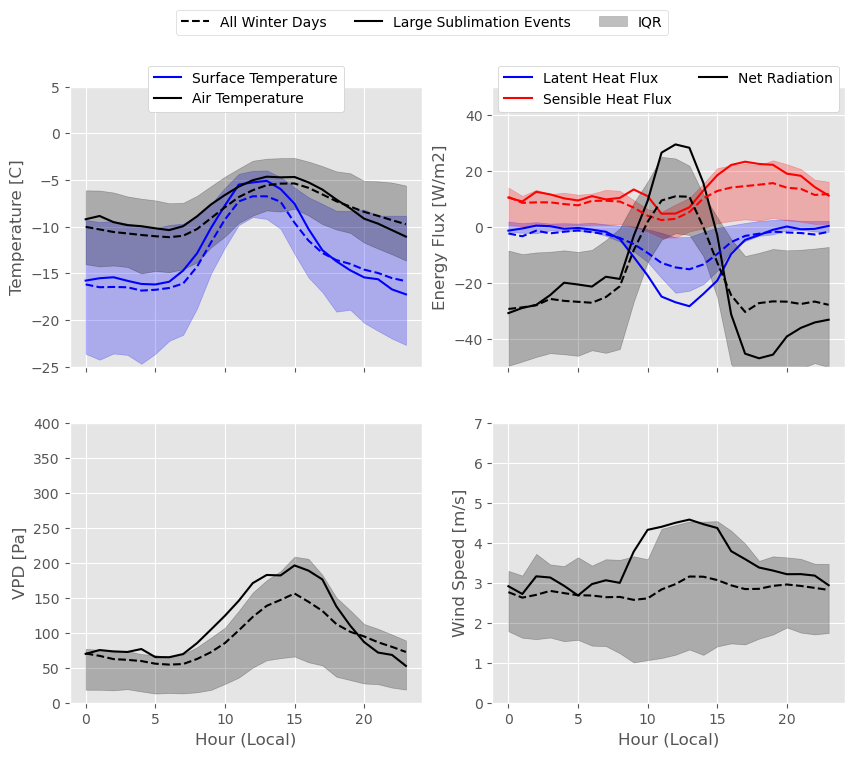

In [27]:
# Compare all winter days to large sublimation events
# plot style
plt.style.use('ggplot')
# Create a figure with gridspec layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()

#----------- Surface and Air Temperature -----------
# Average values for large sublimation events
axs[0].plot(w23_surface_temperature_short_events_hr.hour.values, w23_surface_temperature_short_events_hr.values, color='blue', label='Surface Temperature', ls='solid')
axs[0].plot(w23_temperature_short_events_hr.hour.values, w23_temperature_short_events_hr.values, label='Air Temperature', color='black', ls='solid')

# Average values for all winter days
axs[0].plot(w23_surface_temperature_hr.hour.values, w23_surface_temperature_hr.values, color='blue', ls='dashed')
shade_iqr(axs[0], w23_surface_temperature_hr_top, w23_surface_temperature_hr_bottom, color='blue')
axs[0].plot(w23_temperature_hr.hour.values, w23_temperature_hr.values, color='black', ls='dashed')
shade_iqr(axs[0], w23_temperature_hr_bottom, w23_temperature_hr_top, color='black')

# ax specs
axs[0].set_ylabel('Temperature [C]')
axs[0].legend(ncol=1, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[0].set_ylim(-25,5)

#----------- Compare latent heat flux, sensible heat flux, and net radiation -----------
# Average values for large sublimation events
axs[1].plot(w23_latent_heat_short_events_hr.hour.values, -w23_latent_heat_short_events_hr.values, color='blue', label='Latent Heat Flux', ls='solid')
axs[1].plot(w23_sensible_heat_short_events_hr.hour.values, -w23_sensible_heat_short_events_hr.values, color='red', label='Sensible Heat Flux', ls='solid')
axs[1].plot(w23_rnet_short_events_hr.hour.values, w23_rnet_short_events_hr.values, color='black', label='Net Radiation', ls='solid')

# Average values for all winter days
axs[1].plot(w23_latent_heat_hr.hour.values, -w23_latent_heat_hr.values, color='blue', ls='dashed')
shade_iqr(axs[1], -w23_latent_heat_hr_top, -w23_latent_heat_hr_bottom, color='blue')
axs[1].plot(w23_sensible_heat_hr.hour.values, -w23_sensible_heat_hr.values, color='red', ls='dashed')
shade_iqr(axs[1], -w23_sensible_heat_hr_top, -w23_sensible_heat_hr_bottom, color='red')
axs[1].plot(w23_rnet_hr.hour.values, w23_rnet_hr.values, color='black', ls='dashed')
shade_iqr(axs[1], w23_rnet_hr_top, w23_rnet_hr_bottom, color='black')

# ax specs
axs[1].set_ylabel('Energy Flux [W/m2]')
axs[1].legend(ncol=2, framealpha=1, bbox_to_anchor=(0.5, 1.1), loc='upper center', facecolor='white')
axs[1].set_ylim(-50, 50)

#----------- compare vapor pressure deficit -----------
# Average values for large sublimation events
axs[2].plot(w23_vpd_short_events_hr.hour.values, w23_vpd_short_events_hr.values, color='black', ls='solid')

# Average values for all winter days
axs[2].plot(w23_vpd_hr.hour.values, w23_vpd_hr.values, color='black', ls='dashed')
shade_iqr(axs[2], w23_vpd_hr_top, w23_vpd_hr_bottom, color='black')

# ax specs
axs[2].set_ylabel('VPD [Pa]')
axs[2].set_xlabel('Hour (Local)')
axs[2].set_ylim(0,400)

#----------- compare wind speed -----------
# Average values for large sublimation events
axs[3].plot(w23_wind_speed_short_events_hr.hour.values, w23_wind_speed_short_events_hr.values, color='black', label='Wind Speed @ 10m', ls='solid')

# Average values for all winter days
axs[3].plot(w23_wind_speed_hr.hour.values, w23_wind_speed_hr.values, color='black', ls='dashed')
shade_iqr(axs[3], w23_wind_speed_hr_top, w23_wind_speed_hr_bottom, color='black')
axs[3].set_ylabel('Wind Speed [m/s]')
axs[3].set_xlabel('Hour (Local)')
axs[3].set_ylim(0,7)

###### create dummy plot for legend ######
fake_ax = axs[0].twinx()
# turn off all labels and spines for this axis
fake_ax.axis('off')
fake_ax.plot([],[], color='black', label='All Winter Days', ls='dashed')
fake_ax.plot([],[], color='black', label='Large Sublimation Events', ls='solid')
fake_ax.fill_between([],[],[], color='grey', alpha=0.5, label='IQR')
fake_ax.legend(loc='upper center', bbox_to_anchor=(1., 1.3), ncol=3, facecolor='white')

# Combined Years

In [28]:
temperature = w22_splash_ap_ds['temp'] * units.units.degC
wind_speed = w22_splash_ap_ds['wspd_vec_mean'] * units.units('m/s')
surface_temperature = w22_splash_ap_ds['skin_temp_surface'] * units.units.degC
mr = w22_splash_ap_ds['mixing_ratio']/1000
vpd = mpcalc.saturation_vapor_pressure(temperature) - mpcalc.vapor_pressure(w22_splash_ap_ds['atmos_pressure'] * units.units.hPa, mr).metpy.convert_units('Pa')
rnet = (w22_splash_ap_ds['down_short_hemisp'] - w22_splash_ap_ds['up_short_hemisp'] ) + (w22_splash_ap_ds['down_long_hemisp'] - w22_splash_ap_ds['up_long_hemisp'] )
rnet = rnet.where((w22_splash_ap_ds[['down_short_hemisp_qc', 'up_short_hemisp_qc', 'down_long_hemisp_qc', 'up_long_hemisp_qc']]==0).to_pandas().all(axis=1).values, np.nan)
rnet = rnet.where(w22_splash_ap_ds['up_short_hemisp'] - w22_splash_ap_ds['down_short_hemisp'] <=5, np.nan).interpolate_na('time')
latent_heat = -w22_splash_ap_ds['Hl'] * units.units('W/m^2')
sensible_heat = -w22_splash_ap_ds['Hs'] * units.units('W/m^2')

In [29]:
def merge_splash_sos_data(ds1, ds2, variable):
    """
    This function will merge a variable the splash and sos datasets
    """
    ds1.name = variable
    ds2.name = variable

    # slice each to the length of each winter
    ds1 = ds1.sel(time=slice('2021-12-01','2022-03-31'))
    ds2 = ds2.sel(time=slice('2022-12-01','2023-03-31'))
    
    try:
        a = ds1.metpy.units
        if a != units.units.dimensionless:
            pass
        else:
            ds1 = ds1 * ds2.metpy.units
    except AttributeError:
        ds1 = ds1 * ds2.metpy.units
    # concatenate the datasets
    ds = xr.concat([ds1, ds2], dim='time')
    return ds

all_temperature = merge_splash_sos_data(temperature, sos_30min_T['T_3m_c'], 'temperature')
all_wind_speed = merge_splash_sos_data(wind_speed, sos_30min_winds['spd_3m_c']* units.units('m/s'), 'wind_speed')
all_surface_temperature = merge_splash_sos_data(surface_temperature, sos_30min_Tsurf_d* units.units('degC'), 'surface_temperature')
all_vpd = merge_splash_sos_data(vpd, sos_30min_vpd['vpd_3m_c'], 'vpd')
all_rnet = merge_splash_sos_data(rnet, sos_30min_rad['rnet'], 'rnet')
all_latent_heat = merge_splash_sos_data(latent_heat, -sos_30min_Hl_webb_3m['sos_3m'], 'latent_heat')
all_sensible_heat = merge_splash_sos_data(sensible_heat, -sos_30min_sensible_heat, 'sensible_heat')

In [30]:
# Get the diurnal average for each 
all_temperature_hr = all_temperature.groupby('time.hour').mean()
all_wind_speed_hr = all_wind_speed.groupby('time.hour').mean()
all_surface_temperature_hr = all_surface_temperature.groupby('time.hour').mean()
all_vpd_hr = all_vpd.groupby('time.hour').mean()
all_rnet_hr = all_rnet.groupby('time.hour').mean()
all_latent_heat_hr = all_latent_heat.groupby('time.hour').mean()
all_sensible_heat_hr = all_sensible_heat.groupby('time.hour').mean()

# get the top quartile of each
all_temperature_hr_top = all_temperature.groupby('time.hour').quantile(0.75)
all_wind_speed_hr_top = all_wind_speed.groupby('time.hour').quantile(0.75)
all_surface_temperature_hr_top = all_surface_temperature.groupby('time.hour').quantile(0.75)
all_vpd_hr_top = all_vpd.groupby('time.hour').quantile(0.75)
all_rnet_hr_top = all_rnet.groupby('time.hour').quantile(0.75)
all_latent_heat_hr_top = all_latent_heat.groupby('time.hour').quantile(0.75)
all_sensible_heat_hr_top = all_sensible_heat.groupby('time.hour').quantile(0.75)

# get the bottom quartile of each
all_temperature_hr_bottom = all_temperature.groupby('time.hour').quantile(0.25)
all_wind_speed_hr_bottom = all_wind_speed.groupby('time.hour').quantile(0.25)
all_surface_temperature_hr_bottom = all_surface_temperature.groupby('time.hour').quantile(0.25)
all_vpd_hr_bottom = all_vpd.groupby('time.hour').quantile(0.25)
all_rnet_hr_bottom = all_rnet.groupby('time.hour').quantile(0.25)
all_latent_heat_hr_bottom = all_latent_heat.groupby('time.hour').quantile(0.25)
all_sensible_heat_hr_bottom = all_sensible_heat.groupby('time.hour').quantile(0.25)


In [31]:
# adjust 2023 long events by the number of events in 2022
w23_long_events['event_number'] = w23_long_events['event_number'] + len(w22_long_events['event_number'].unique())
w23_short_events['event_number'] = w23_short_events['event_number'] + len(w22_short_events['event_number'].unique())
# concatenate all the events
all_long_events = pd.concat([w22_long_events, w23_long_events]).reset_index()
all_short_events = pd.concat([w22_short_events, w23_short_events]).reset_index()

# get the start and end times for each event
all_long_events_start = all_long_events.groupby('event_number').first()['index']
all_long_events_end = all_long_events.groupby('event_number').last()['index']
all_short_events_start = all_short_events.groupby('event_number').first()['index']
all_short_events_end = all_short_events.groupby('event_number').last()['index']

In [32]:
all_temperature_long_events_hr = []
all_wind_speed_long_events_hr = []
all_surface_temperature_long_events_hr = []
all_vpd_long_events_hr = []
all_rnet_long_events_hr = []
all_latent_heat_long_events_hr = []
all_sensible_heat_long_events_hr = []


for i in range(len(all_long_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = all_long_events_start.iloc[i], all_long_events_end.iloc[i]
    
    # get data for plots
    temperature_sel = all_temperature.sel(time=slice(start, end))
    wind_speed_sel = all_wind_speed.sel(time=slice(start, end))
    surface_temperature_sel = all_surface_temperature.sel(time=slice(start, end))
    vpd_sel = all_vpd.sel(time=slice(start, end))
    rnet_sel = all_rnet.sel(time=slice(start, end))
    latent_heat_sel = all_latent_heat.sel(time=slice(start, end))
    sensible_heat_sel = all_sensible_heat.sel(time=slice(start, end))

    # append all events to their respective lists
    all_temperature_long_events_hr.append(temperature_sel)
    all_wind_speed_long_events_hr.append(wind_speed_sel)
    all_surface_temperature_long_events_hr.append(surface_temperature_sel)
    all_vpd_long_events_hr.append(vpd_sel)
    all_rnet_long_events_hr.append(rnet_sel)
    all_latent_heat_long_events_hr.append(latent_heat_sel)
    all_sensible_heat_long_events_hr.append(sensible_heat_sel)


# concatenate all the events
all_temperature_long_events_hr = xr.concat(all_temperature_long_events_hr, dim='time').groupby('time.hour').mean()  
all_wind_speed_long_events_hr = xr.concat(all_wind_speed_long_events_hr, dim='time').groupby('time.hour').mean()  
all_surface_temperature_long_events_hr = xr.concat(all_surface_temperature_long_events_hr, dim='time').groupby('time.hour').mean()  
all_vpd_long_events_hr = xr.concat(all_vpd_long_events_hr, dim='time').groupby('time.hour').mean()  
all_rnet_long_events_hr = xr.concat(all_rnet_long_events_hr, dim='time').groupby('time.hour').mean()  
all_latent_heat_long_events_hr = xr.concat(all_latent_heat_long_events_hr, dim='time').groupby('time.hour').mean()  
all_sensible_heat_long_events_hr = xr.concat(all_sensible_heat_long_events_hr, dim='time').groupby('time.hour').mean()  

In [33]:
all_temperature_short_events_hr = []
all_wind_speed_short_events_hr = []
all_surface_temperature_short_events_hr = []
all_vpd_short_events_hr = []
all_rnet_short_events_hr = []
all_latent_heat_short_events_hr = []
all_sensible_heat_short_events_hr = []


for i in range(len(all_short_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = all_short_events_start.iloc[i].date(), all_short_events_start.iloc[i].date() + pd.Timedelta('1 day')
    
    # get data for plots
    temperature_sel = all_temperature.sel(time=slice(start, end))
    wind_speed_sel = all_wind_speed.sel(time=slice(start, end))
    surface_temperature_sel = all_surface_temperature.sel(time=slice(start, end))
    vpd_sel = all_vpd.sel(time=slice(start, end))
    rnet_sel = all_rnet.sel(time=slice(start, end))
    latent_heat_sel = all_latent_heat.sel(time=slice(start, end))
    sensible_heat_sel = all_sensible_heat.sel(time=slice(start, end))

    # append all events to their respective lists
    all_temperature_short_events_hr.append(temperature_sel)
    all_wind_speed_short_events_hr.append(wind_speed_sel)
    all_surface_temperature_short_events_hr.append(surface_temperature_sel)
    all_vpd_short_events_hr.append(vpd_sel)
    all_rnet_short_events_hr.append(rnet_sel)
    all_latent_heat_short_events_hr.append(latent_heat_sel)
    all_sensible_heat_short_events_hr.append(sensible_heat_sel)


# concatenate all the events
all_temperature_short_events_hr = xr.concat(all_temperature_short_events_hr, dim='time').groupby('time.hour').mean()  
all_wind_speed_short_events_hr = xr.concat(all_wind_speed_short_events_hr, dim='time').groupby('time.hour').mean()  
all_surface_temperature_short_events_hr = xr.concat(all_surface_temperature_short_events_hr, dim='time').groupby('time.hour').mean()  
all_vpd_short_events_hr = xr.concat(all_vpd_short_events_hr, dim='time').groupby('time.hour').mean()  
all_rnet_short_events_hr = xr.concat(all_rnet_short_events_hr, dim='time').groupby('time.hour').mean()  
all_latent_heat_short_events_hr = xr.concat(all_latent_heat_short_events_hr, dim='time').groupby('time.hour').mean()  
all_sensible_heat_short_events_hr = xr.concat(all_sensible_heat_short_events_hr, dim='time').groupby('time.hour').mean()  

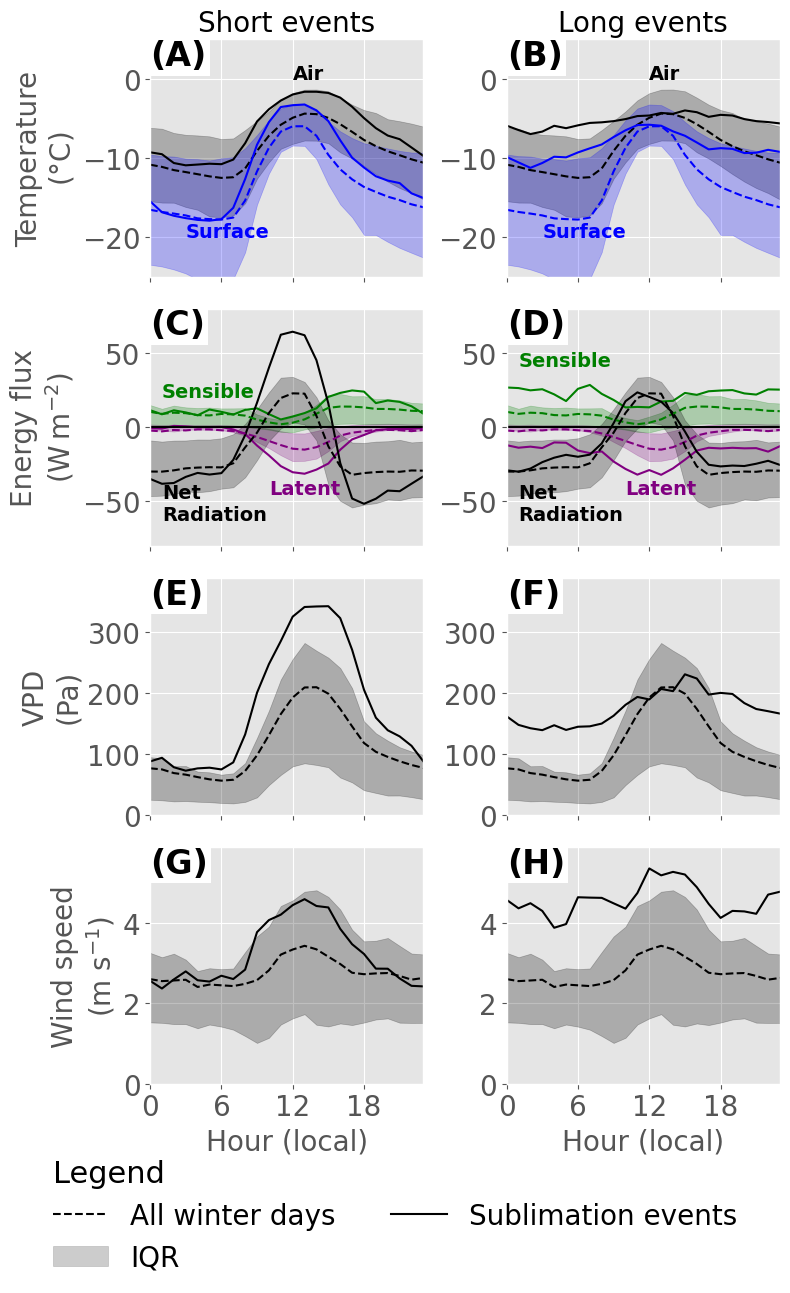

In [34]:
save_fig=True
# master font size
plot_font_size = 20

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 12), sharex=True)
hour_ticks = [0, 6, 12, 18]  # custom x‑axis ticks

def series_for(evt, short_ser, long_ser):
    return short_ser if evt == "short" else long_ser

for c, evt in enumerate(["short", "long"]):
    # ───────── TEMPERATURE ─────────────
    ax = axs[0, c]
    surf = series_for(evt, all_surface_temperature_short_events_hr,
                           all_surface_temperature_long_events_hr)
    air = series_for(evt, all_temperature_short_events_hr,
                            all_temperature_long_events_hr)
    ax.plot(air.hour, air, color="black", ls="-")
    ax.plot(all_temperature_hr.hour, all_temperature_hr, color="black", ls="--")
    shade_iqr(ax, all_temperature_hr_top, all_temperature_hr_bottom, color="black")

    ax.plot(surf.hour, surf, color="blue", ls="-")
    ax.plot(all_surface_temperature_hr.hour, all_surface_temperature_hr, color="blue", ls="--")
    shade_iqr(ax, all_surface_temperature_hr_top, all_surface_temperature_hr_bottom, color="blue")
    ax.set_ylim(-25, 5)
    if c == 1:
        ax.text(12, 0, "Air", color="black", fontsize=plot_font_size-6, fontweight="bold")
        ax.text(3, -20, "Surface", color="blue", fontsize=plot_font_size-6,  fontweight="bold")
    if c == 0:
        ax.set_ylabel("Temperature\n($\degree$C)", fontsize=plot_font_size)
        ax.text(12, 0, "Air", color="black", fontsize=plot_font_size-6,  fontweight="bold")
        ax.text(3, -20, "Surface", color="blue", fontsize=plot_font_size-6,  fontweight="bold")

    ax.set_title(f"{evt.capitalize()} events", fontsize=plot_font_size)

    # ───────── ENERGY FLUXES ───────────
    ax = axs[1, c]
    for ser, col in [
        (series_for(evt, all_latent_heat_short_events_hr,
                         all_latent_heat_long_events_hr), "purple"),
        (series_for(evt, all_sensible_heat_short_events_hr,
                         all_sensible_heat_long_events_hr), "green"),
        (series_for(evt, all_rnet_short_events_hr,
                         all_rnet_long_events_hr), "black"),
    ]:
        ax.plot(ser.hour, ser, color=col, ls="-")
    for ser, top, bot, col in [
        (all_latent_heat_hr, all_latent_heat_hr_top, all_latent_heat_hr_bottom, "purple"),
        (all_sensible_heat_hr, all_sensible_heat_hr_top, all_sensible_heat_hr_bottom, "green"),
        (all_rnet_hr, all_rnet_hr_top, all_rnet_hr_bottom, "black"),
    ]:
        ax.plot(ser.hour, ser, color=col, ls="--")
        shade_iqr(ax, top, bot, color=col)
    ax.set_ylim(-80, 80)
    ax.axhline(0, color="black", ls="-")
    if c == 1:
        ax.text(10, -45, "Latent", color="purple", fontsize=plot_font_size-6, fontweight="bold")
        ax.text(1, 41, "Sensible", color="green", fontsize=plot_font_size-6,  fontweight="bold")
        ax.text(1, -63, "Net\nRadiation", color="black", fontsize=plot_font_size-6,  fontweight="bold")
    if c == 0:
        ax.set_ylabel("Energy flux\n(W m$^{-2}$)", fontsize=plot_font_size)
        ax.text(10, -45, "Latent", color="purple", fontsize=plot_font_size-6,  fontweight="bold")
        ax.text(1, 20, "Sensible", color="green", fontsize=plot_font_size-6,  fontweight="bold")
        ax.text(1, -63, "Net\nRadiation", color="black", fontsize=plot_font_size-6,  fontweight="bold")

    # ───────── VPD ─────────────────────
    ax = axs[2, c]
    vpd = series_for(evt, all_vpd_short_events_hr, all_vpd_long_events_hr)
    ax.plot(vpd.hour, vpd, color="black", ls="-")
    ax.plot(all_vpd_hr.hour, all_vpd_hr, color="black", ls="--")
    shade_iqr(ax, all_vpd_hr_top, all_vpd_hr_bottom, color="black")
    ax.set_ylim(0, 390)
    if c == 0:
        ax.set_ylabel("VPD\n(Pa)", fontsize=plot_font_size)

    # ───────── WIND SPEED ──────────────
    ax = axs[3, c]
    ws = series_for(evt, all_wind_speed_short_events_hr,
                         all_wind_speed_long_events_hr)
    ax.plot(ws.hour, ws, color="black", ls="-")
    ax.plot(all_wind_speed_hr.hour, all_wind_speed_hr, color="black", ls="--")
    shade_iqr(ax, all_wind_speed_hr_top, all_wind_speed_hr_bottom, color="black")
    ax.set_ylim(0, 5.9)
    ax.set_xlabel("Hour (local)", fontsize=plot_font_size)
    if c == 0:
        ax.set_ylabel("Wind speed\n(m s$^{-1}$)", fontsize=plot_font_size)

# Format all axes
for r in range(4):
    for c in range(2):
        axs[r, c].set_xlim(0, 23)
        axs[r, c].set_xticks(hour_ticks)
        axs[r, c].tick_params(axis="both", labelsize=plot_font_size)

# --- add (A)–(H) panel labels in white boxes ----------------------
panel_labels = list("ABCDEFGH")
for idx, ax in enumerate(axs.flat):
    if idx >= len(panel_labels):
        break
    ax.text(
        0.0, 1, f"({panel_labels[idx]})",
        transform=ax.transAxes,
        fontsize=plot_font_size + 4,
        fontweight="bold",
        ha="left", va="top",
        bbox=dict(facecolor="white", edgecolor="none", pad=2.5, alpha=1)
    )

# --- shared legend ---
handles = [
    plt.Line2D([], [], color="black", ls="--", label="All winter days"),
    plt.Rectangle((0, 0), 1, 1, color="grey", alpha=0.4, label="IQR"),
    plt.Line2D([], [], color="black", ls="-",  label="Sublimation events")
]
fig.legend(handles=handles, ncol=2, loc="upper center", framealpha=0,
           bbox_to_anchor=(0.5, 0.03), fontsize=plot_font_size,
           title="Legend", 
           alignment="left",
           title_fontsize=plot_font_size + 2)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# save fig
if save_fig:
    fig.savefig('04_products/figures/draft/sublimation_events_diurnal_comparison.png',
                bbox_inches='tight', dpi=300, facecolor='white')

In [ ]:
all_latent_heat_short_events_hr,
all_latent_heat_long_events_hr
all_sensible_heat_short_events_hr,
all_sensible_heat_long_events_hr
all_rnet_short_events_hr, all_rnet_long_events_hr

In [43]:
a = np.corrcoef(
    all_latent_heat_short_events_hr.values.flatten(),
    all_sensible_heat_short_events_hr.values.flatten()
)[0, 1]
print(f"Correlation between latent heat and sensible heat for short events: {round(a, 2)}")

b = np.corrcoef(
    all_latent_heat_long_events_hr.values.flatten(),
    all_sensible_heat_long_events_hr.values.flatten()
)[0, 1]
print(f"Correlation between latent heat and sensible heat for long events: {round(b, 2)}")

c = np.corrcoef(
    all_rnet_short_events_hr.values.flatten(),
    all_latent_heat_short_events_hr.values.flatten()
)[0, 1]
print(f"Correlation between net radiation and latent heat for short events: {round(c, 2)}")

d = np.corrcoef(
    all_rnet_long_events_hr.values.flatten(),
    all_latent_heat_long_events_hr.values.flatten()
)[0, 1]
print(f"Correlation between net radiation and latent heat for long events: {round(d, 2)}")

Correlation between latent heat and sensible heat for short events: 0.08
Correlation between latent heat and sensible heat for long events: 0.76
Correlation between net radiation and latent heat for short events: -0.91
Correlation between net radiation and latent heat for long events: -0.96
